In [9]:
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding

# Please write the optimal hyperparameter values you obtain in the global variable 'optimal_hyperparm' below. This
# variable should contain the values when I look at your submission. I should not have to run your code to populate this
# variable.
optimal_hyperparam = {'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}


class COC131:
    def __init__(self):
        self.x = None
        self.y = None
        self.scaler = None
        self.best_hyperparams = None

    def q1(self, filename=None):
        
        """
        Loads the dataset from the local '../dataset' directory, resizes all images to 32x32, 
        and flattens them into 1D arrays. Class labels are inferred from folder names. The processed 
        data is stored in instance variables `self.x` (features) and `self.y` (labels).
    
        If a specific filename is provided, the function also returns the processed image and 
        its class label.
    
        Parameters:
            filename (str, optional): Name of a specific image file to return after processing.
                                      Defaults to None.
    
        Returns:
            res1 (np.ndarray or np.ndarray): 
                - If `filename` is provided: 1D numpy array of the flattened image.
                - Else: Array of all flattened images.
            
            res2 (str or np.ndarray): 
                - If `filename` is provided: Class label of the image.
                - Else: Array of all class labels.
        """
        
        # Get all subfolders within the dataset directory
        subfolders = [entry.path for entry in os.scandir("../dataset") if entry.is_dir()]
    
        # Creates a list of all paths for the images stored within the ../dataset directory
        image_paths = [os.path.join(subfolder, file)
                     for subfolder in subfolders
                     for file in os.listdir(subfolder) if file.endswith(('.jpg'))] # If the file is an image
    
        # Processes each image within the dataset directory and stores it into the images array
        self.x = np.array([np.array(Image.open(image_path).resize((32, 32)), dtype=float).flatten() for image_path in image_paths])
    
        # Gets the name of the folder that the image is stored in (the classification of the image)
        self.y = np.array([os.path.basename(os.path.dirname(image_path)) for image_path in image_paths])
    
        # If a filename is provided, find and return it
        if filename:
            matching_image_path = next((image_path for image_path in image_paths if filename in image_path), None) # Get filepath
            
            if matching_image_path:
                res1 = np.array(Image.open(matching_image_path).resize((32, 32)), dtype=float).flatten() # Flatten image to 32 * 32
                res2 = os.path.basename(os.path.dirname(matching_image_path))  # Extract class name
                return res1, res2
                
        return self.x, self.y
    
    def q2(self, inp):
        """
        Standardises the input data using sklearn's StandardScaler and scales the result 
        to have a standard deviation of 2.5.
    
        This function fits a StandardScaler to the input and transforms it, 
        then multiplies the standardised result to adjust the standard deviation.
    
        Parameters:
            inp (np.ndarray): Input array of shape (n_samples, n_features) to be standardised.
    
        Returns:
            res2 (np.ndarray): The standardised data with a standard deviation of 2.5, 
                               same shape as the input.
            res1 (StandardScaler): The fitted StandardScaler object used for standardisation.
        """
        
        standard_scaler = StandardScaler() # Creates a sklearn object used for standardisation
        standardised_data = standard_scaler.fit_transform(inp) # Standardises the data (setting the standard deviation to 1)

        res1 = standard_scaler
        res2 = standardised_data * 2.5 # Standardises the data to have a standard deviation of 2.5

        return res2, res1
        
    @staticmethod
    def visualise_standardisation_means_stds(unscaled_data, scaled_data):
        """
        Visualises the impact of standardisation on feature-wise statistics.
    
        This function generates two side-by-side scatter plots:
        - The first compares the mean values of each feature before and after standardisation.
        - The second compares the standard deviations of each feature before and after standardisation.
    
        Useful for verifying that the scaling process has centered the data around 0 
        and adjusted the spread (standard deviation) as expected.
    
        Parameters
        ----------
        unscaled_data : np.ndarray
            The original dataset prior to standardisation, of shape (n_samples, n_features).
    
        scaled_data : np.ndarray
            The dataset after standardisation, of shape (n_samples, n_features).
    
        Returns
        -------
        None
            Displays the plots directly using matplotlib.
        """

        # Get the number of features (columns), used as x-axis for plotting
        feature_ids = np.arange(unscaled_data.shape[1])
        
        # Compute means for each feature before and after standardization
        unscaled_means = np.mean(unscaled_data, axis=0)
        scaled_means = np.mean(scaled_data, axis=0)

        # Compute standard deviations for each feature before and after standardisation
        unscaled_standard_deviations = np.std(unscaled_data, axis=0)
        scaled_standard_deviations = np.std(scaled_data, axis=0)

        # Determine plot limits so both datasets are visible in the same scale
        mean_ylim = (min(unscaled_means.min(), scaled_means.min()),
                     max(unscaled_means.max(), scaled_means.max()))
        
        standard_deviation_ylim = (min(unscaled_standard_deviations.min(), scaled_standard_deviations.min()),
                                   max(unscaled_standard_deviations.max(), scaled_standard_deviations.max()))

        # Create side-by-side plots
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Plot feature-wise means
        axs[0].scatter(feature_ids, unscaled_means, label="Original", alpha=0.6)
        axs[0].scatter(feature_ids, scaled_means, label="Standardised", alpha=0.6)
        axs[0].set_title("Feature-wise Means Before and After Standardisation")
        axs[0].set_xlabel("Feature Index")
        axs[0].set_ylabel("Mean Value")
        axs[0].legend()
        axs[0].set_ylim(mean_ylim)

        # Plot feature-wise standard deviations
        axs[1].scatter(feature_ids, unscaled_standard_deviations, label="Original", alpha=0.6)
        axs[1].scatter(feature_ids, scaled_standard_deviations, label="Standardised", alpha=0.6)
        axs[1].set_title("Feature-wise Standard Deviations Before and After Standardisation")
        axs[1].set_xlabel("Feature Index")
        axs[1].set_ylabel("Standard Deviation")
        axs[1].legend()
        axs[1].set_ylim(standard_deviation_ylim)

        # Adjust layout and display both plots
        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualise_hyperparam_results(param_labels, cv_scores):
        """
        Visualises the mean cross-validation accuracy for different hyperparameter configurations.
    
        This function generates a horizontal bar chart, where each bar represents a different
        hyperparameter combination tested during model selection, and its corresponding
        average cross-validation accuracy.
    
        Parameters
        ----------
        param_labels : list of str
            A list of string labels representing the hyperparameter configurations.
    
        cv_scores : list or np.ndarray
            A list or array of mean cross-validation accuracy scores corresponding to each
            hyperparameter combination.
    
        Returns
        -------
        None
            Displays the plot directly using matplotlib.
        """
        
        plt.figure(figsize=(12, 6))
        plt.barh(param_labels, cv_scores, color='skyblue')
        plt.xlabel("Mean Cross-Validation Accuracy")
        plt.title("Hyperparameter Optimisation Results")
        plt.gca().invert_yaxis()
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def q3(self, test_size=None, pre_split_data=None, hyperparam=None):
        """
        Trains a Multi-Layer Perceptron (MLP) classifier and evaluates its performance over training iterations.
    
        If hyperparameters are provided, they are used directly. Otherwise, performs grid search
        to determine the best parameter combination. Tracks the loss, training accuracy, and testing accuracy
        after each training iteration.
    
        Parameters
        ----------
        test_size : float, optional
            Proportion of the dataset to be used as the test set. Defaults to 0.3.
    
        pre_split_data : tuple, optional
            Tuple of (x_train, x_test, y_train, y_test). If provided, the data will not be split again.
    
        hyperparam : dict, optional
            Dictionary of hyperparameters for the MLPClassifier. If not provided, grid search is used.
    
        Returns
        -------
        model : MLPClassifier
            The trained classifier.
    
        loss_per_iteration : np.ndarray
            Loss recorded at each training iteration.
    
        training_accuracy_per_iteration : np.ndarray
            Training accuracy measured after each iteration.
    
        testing_accuracy_per_iteration : np.ndarray
            Testing accuracy measured after each iteration.
        """
        # Standardise data using q2 if not already done
        if self.scaler is None:
            self.x, self.scaler = self.q2(self.x)
    
        # Use provided train/test split if available, else perform a new split
        if pre_split_data:
            x_train, x_test, y_train, y_test = pre_split_data
        else:
            x_train, x_test, y_train, y_test = train_test_split(
                self.x, self.y, test_size=test_size or 0.3, random_state=1
            )
    
        # Perform hyperparameter optimisation if none provided
        if hyperparam is None:
            param_grid = {
                "hidden_layer_sizes": [(50,), (100,), (100, 50), (200,)],
                "learning_rate": ["constant", "adaptive"],
                "solver": ["adam", "sgd"],
                "max_iter": [1000],  # Used during search only
            }
    
            # Conduct grid search with 3-fold cross-validation
            grid_search = GridSearchCV(
                MLPClassifier(random_state=1),
                param_grid,
                cv=3
            )
            grid_search.fit(x_train, y_train)
    
            # Visualise and record the best parameters
            labels = [str(hyperparam_set) for hyperparam_set in grid_search.cv_results_["params"]]
            scores = grid_search.cv_results_["mean_test_score"]
            self.visualise_hyperparam_results(labels, scores)
    
            hyperparam = grid_search.best_params_
            self.best_hyperparams = hyperparam
    
        # Set up the model for iteration-wise training
        model = MLPClassifier(**hyperparam, random_state=1, warm_start=True, max_iter=1)
        max_iterations = 1000  # Number of training iterations
    
        # Initialise tracking lists
        loss_per_iteration = []
        training_accuracy_per_iteration = []
        testing_accuracy_per_iteration = []
    
        # Train the model one iteration at a time
        for i in range(max_iterations):
            model.fit(x_train, y_train)
    
            # Record training loss if available
            if hasattr(model, "loss_"):
                loss_per_iteration.append(model.loss_)
    
            # Calculate accuracy for training and testing sets
            training_acc = accuracy_score(y_train, model.predict(x_train))
            testing_acc = accuracy_score(y_test, model.predict(x_test))
    
            training_accuracy_per_iteration.append(training_acc)
            testing_accuracy_per_iteration.append(testing_acc)
    
            # Optional early stopping if the model has converged
            if hasattr(model, "n_iter_") and model.n_iter_ >= max_iterations:
                break
    
        # Return the trained model and performance metrics
        return (
            model,
            np.array(loss_per_iteration),
            np.array(training_accuracy_per_iteration),
            np.array(testing_accuracy_per_iteration)
        )


    
    def q4(self):
        """
        Evaluates the impact of L2 regularisation (alpha) on model complexity.
    
        For each alpha value in a predefined list, trains an MLPClassifier using the best
        hyperparameters found in `q3` (with `alpha` overwritten). The function measures
        the total magnitude (L1 norm) of the model's weights and biases to assess how
        regularisation strength affects parameter magnitudes.
    
        Assumes `q1()` has been called to load the dataset and that `self.best_hyperparams`
        has been populated with valid hyperparameters.
    
        Returns
        -------
        res : dict
            Dictionary containing the following keys:
            - "alpha_values": list of alpha values tested.
            - "total_weights": list of total weight magnitudes (L1 norm) for each model.
            - "total_biases": list of total bias magnitudes (L1 norm) for each model.
        """
        
        # Split data into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.3, random_state=1)
    
        alpha_values = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 50, 100]

        # Lists to store total magnitude of weights and biases for each alpha
        total_weights = []
        total_biases = []

        # Loop through each alpha value and train a MLPClassifier model
        for alpha in alpha_values:
            hyperparams = self.best_hyperparams.copy()
            hyperparams["alpha"] = alpha

            # Create and train the MLPClassifier with current alpha value
            model = MLPClassifier(**hyperparams, random_state=1)
            model.fit(x_train, y_train)
    
            # Calculate the sum of absolute weights and biases
            weight_sum = sum(np.sum(np.abs(w)) for w in model.coefs_)
            bias_sum = sum(np.sum(np.abs(b)) for b in model.intercepts_)

            # Add results to lists
            total_weights.append(weight_sum)
            total_biases.append(bias_sum)

        # Store results in a dictionary
        res = {
            "alpha_values": alpha_values,
            "total_weights": total_weights,
            "total_biases": total_biases
        }
    
        return res

    
    @staticmethod
    def visualise_alpha_vs_params(res): # A function created to visualise how different alpha values impact the model parameters and the performance of the model.
        """
        Visualises the effect of regularisation strength (alpha) on model parameters.
    
        Generates a line plot showing how different values of the alpha parameter
        affect the total L1 norm (magnitude) of the weights and biases in the 
        trained MLPClassifier. The x-axis is displayed on a logarithmic scale 
        to account for the wide range of alpha values.
    
        Parameters
        ----------
        res : dict
            Dictionary output from q4(), containing:
            - "alpha_values": list of alpha values tested
            - "total_weights": list of total weight magnitudes (L1 norm) for each alpha
            - "total_biases": list of total bias magnitudes (L1 norm) for each alpha
        """
        
        # Extract data from the results dictionary
        alphas = res["alpha_values"] # List of alpha (regularisation) values tested
        weights = res["total_weights"] # Corresponding total L1 norm of weights for each alpha
        biases = res["total_biases"] # Corresponding total L1 norm of biases for each alpha
    
        plt.figure(figsize=(8, 5))  # Create a new figure for plotting
        
        plt.plot(alphas, weights, marker='o', label='Total Weights')  # Plot the total weight magnitude against alpha values
        
        plt.plot(alphas, biases, marker='s', label='Total Biases') # Plot the total bias magnitude against alpha values
        
        plt.xscale('log')  # Use logarithmic scale for alpha to better visualise impact across wide range

        # Label the axes
        plt.xlabel("Alpha")
        plt.ylabel("Parameter Magnitude (L1 Norm)")
        
        plt.title("Effect of Alpha on Weights and Biases")  # Set the title

        plt.legend() # Add a legend
        
        plt.grid(True, linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        
        plt.show() # Show the plot


    def q5(self):
        """
        Evaluates the impact of cross-validation splitting strategy on model performance.
    
        This function performs a paired hypothesis test to compare the performance of 
        standard K-Fold Cross-Validation and Stratified K-Fold Cross-Validation when 
        training an MLPClassifier. The function uses the best hyperparameters previously 
        identified (via q3) and reports whether the choice of splitting strategy has a 
        statistically significant effect on accuracy.
    
        Returns
        -------
        res1 : float
            Mean test accuracy using standard K-Fold cross-validation.
    
        res2 : float
            Mean test accuracy using Stratified K-Fold cross-validation.
    
        res3 : float
            p-value from the paired t-test comparing the two accuracy distributions.
    
        res4 : str
            Hypothesis test result. One of:
            - 'Splitting method impacted performance'
            - 'Splitting method had no effect'
        """

        # Use best hyperparameters from q3()
        hyperparams = self.best_hyperparams.copy()
    
        # Define the model
        model = MLPClassifier(**hyperparams, random_state=1)
    
        # Define 5-Fold CV (Without Stratification)
        kf = KFold(shuffle=True, random_state=1)
        cross_value_scores_kf = cross_val_score(model, self.x, self.y, cv=kf, n_jobs=-1)
    
        # Define 5-Fold Stratified CV
        skf = StratifiedKFold(shuffle=True, random_state=1)
        cross_value_scores_skf = cross_val_score(model, self.x, self.y, cv=skf, n_jobs=-1)
    
        # Compute mean testing accuracy
        mean_accuracy_kf = np.mean(cross_value_scores_kf)
        mean_accuracy_skf = np.mean(cross_value_scores_skf)
    
        # Perform paired t-test to compare distributions
        t_stat, p_value = ttest_rel(cross_value_scores_kf, cross_value_scores_skf)
    
        # Determine hypothesis test result
        alpha = 0.05  # Significance level
        if p_value < alpha:
            hypothesis_result = "Splitting method impacted performance"
        else:
            hypothesis_result = "Splitting method had no effect"


        # Assign to return variables as per required format
        res1 = mean_accuracy_kf
        res2 = mean_accuracy_skf
        res3 = p_value
        res4 = hypothesis_result
    
        return res1, res2, res3, res4


    @staticmethod
    def visualise_cv_comparison(scores_kf, scores_skf):
        """
        Visualises and compares accuracy distributions from K-Fold and Stratified K-Fold 
        cross-validation using a boxplot.
    
        Parameters
        ----------
        scores_kf : list or np.ndarray
            Accuracy scores from standard K-Fold cross-validation.
    
        scores_skf : list or np.ndarray
            Accuracy scores from Stratified K-Fold cross-validation.
    
        Returns
        -------
        None
            Displays a boxplot comparing the two cross-validation strategies.
        """
        
        # Combine the two sets of scores into a list for plotting
        data = [scores_kf, scores_skf]  # Each list contains 5 accuracy values (one for each fold)
    
        # Labels for each boxplot group
        method_names = ['K-Fold CV', 'Stratified K-Fold CV']
    
        # Create a figure for the boxplot
        plt.figure(figsize=(8, 5))
    
        # Generate the boxplot
        plt.boxplot(
            data, 
            labels=method_names,            # Label the x-axis with method names
            patch_artist=True,              # Fill boxes with color
            boxprops=dict(facecolor='lightblue'),  # Set box fill color
            medianprops=dict(color='black')        # Set color of the median line
        )
    
        # Add title and axis labels
        plt.title('Cross-Validation Accuracy Comparison')
        plt.ylabel('Accuracy')
    
        # Add horizontal gridlines for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
        # Adjust layout so nothing gets cut off
        plt.tight_layout()
    
        # Display the plot
        plt.show()

        
    def q6(self):
        """
        Applies Locally Linear Embedding (LLE) to reduce the dimensionality of the dataset to 2D.
    
        This method performs unsupervised manifold learning using the LLE algorithm from scikit-learn.
        It projects high-dimensional data into a 2-dimensional space to enable visualisation of class separability.
    
        Returns
        -------
        dict
            A dictionary containing:
            - 'embedded_data' : np.ndarray of shape (n_samples, 2)
                The 2D embedded representation of the input data.
            - 'labels' : np.ndarray of shape (n_samples,)
                The class labels corresponding to each data sample.
        """

        embedding  = LocallyLinearEmbedding(n_components=2) # Instantiate the LLE model with 2 output components (for 2D projection)

        x_transformed = embedding.fit_transform(self.x) # Fit the LLE model to the data and transform it into 2D

        res = { # Place results in a dictionary to be returned: 2D transformed data and class labels
            "embedded_data": x_transformed,
            "labels": self.y
        }
        
        return res

    @staticmethod
    def visualise_lle_separability(embedded_data, labels):
        """
        Visualises the 2D embedded data obtained via Locally Linear Embedding (LLE), 
        using a scatter plot with points colored by their class labels.
    
        Parameters
        ----------
        embedded_data : np.ndarray of shape (n_samples, 2)
            The 2D data representation from LLE transformation.
    
        labels : array-like of shape (n_samples,)
            Class labels corresponding to each data sample. Used for coloring points by class.
    
        Returns
        -------
        None
            Displays a scatter plot. Does not return any value.
        """
        
        labels = np.array(labels) # Convert labels to numpy array for indexing
        unique_classes = np.unique(labels) # Get the unique classes present in the dataset
        colours = plt.colormaps.get_cmap('tab10').resampled(len(unique_classes)) # Get as many colours as there are classes. Each class gets a unique colour

        # Set up the scatter plot
        plt.figure(figsize=(10, 7))
        
        # Plot each class separately
        for i, cls in enumerate(unique_classes):
            idx = labels == cls
            plt.scatter(embedded_data[idx, 0], # X-axis: LLE dimension 1
                        embedded_data[idx, 1], # Y-axis: LLE dimension 2
                        label=cls,
                        alpha=0.7,
                        s=30, c=[colours(i)])  # Assign a distinct color per class

        # Final plot formatting
        plt.title("2D Class Visualisation Using Locally Linear Embedding")
        plt.xlabel("LLE Dimension 1")
        plt.ylabel("LLE Dimension 2")
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


KeyboardInterrupt



In [16]:
model = COC131()
model.q1()  # Load the dataset

(array([[149., 121., 120., ..., 106.,  94., 104.],
        [ 56.,  98.,  84., ..., 173., 127., 112.],
        [ 70.,  92.,  98., ..., 204., 160., 151.],
        ...,
        [ 31.,  55.,  79., ...,  30.,  54.,  82.],
        [ 54.,  71.,  81., ...,  53.,  73.,  82.],
        [102., 100., 109., ...,  96.,  96., 106.]], shape=(27000, 3072)),
 array(['AnnualCrop', 'AnnualCrop', 'AnnualCrop', ..., 'SeaLake',
        'SeaLake', 'SeaLake'], shape=(27000,), dtype='<U20'))

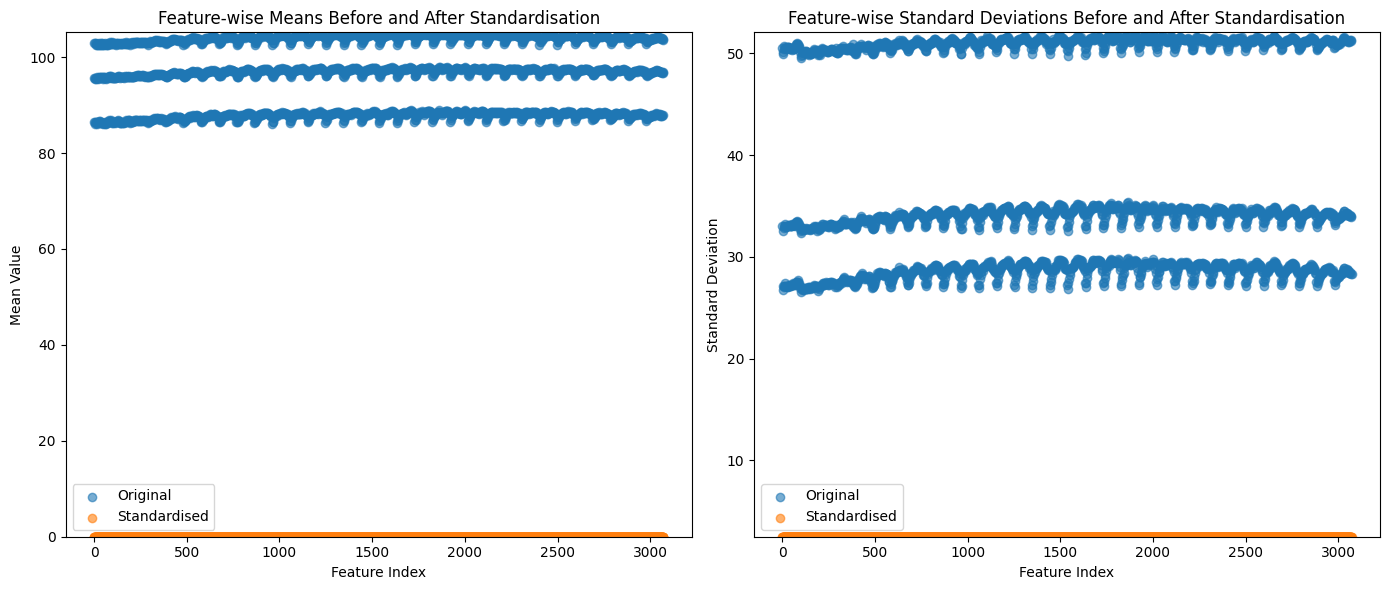

In [17]:
scaled_x, _ = model.q2(model.x)
model.visualise_standardisation_means_stds(model.x, scaled_x)


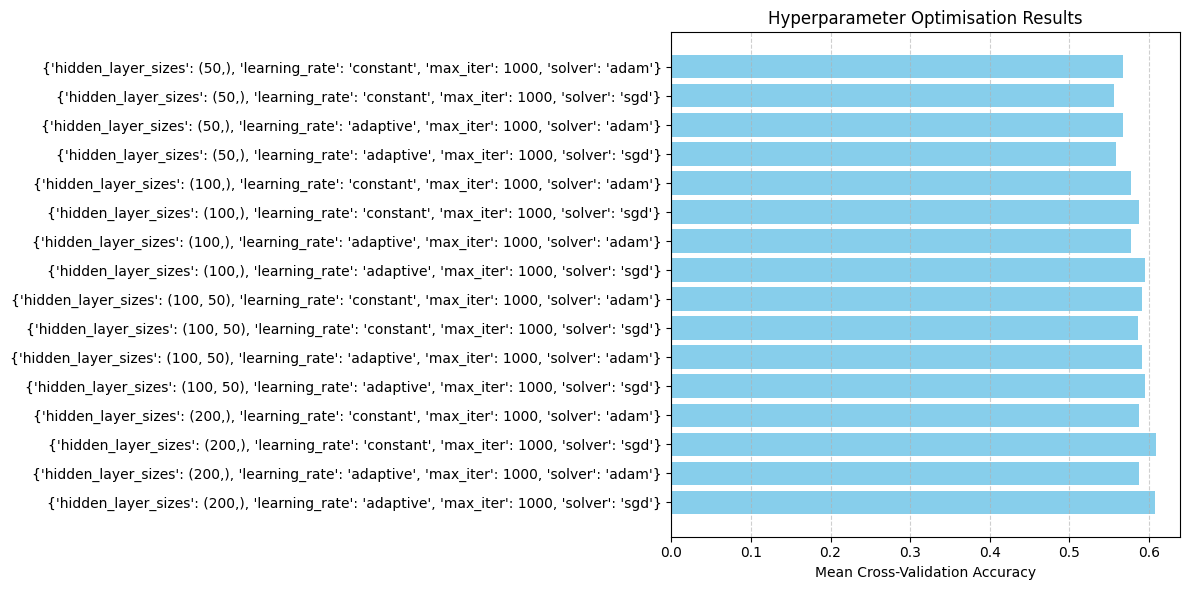

In [18]:
model_obj, losses, train_acc, test_acc = model.q3()


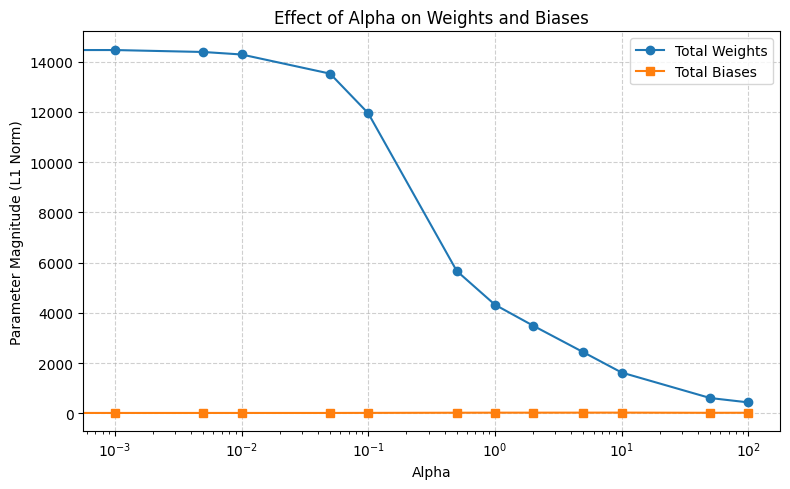

In [19]:
res_q4 = model.q4()
model.visualise_alpha_vs_params(res_q4)  

In [20]:
kf_acc, skf_acc, p_val, hypothesis_result = model.q5()


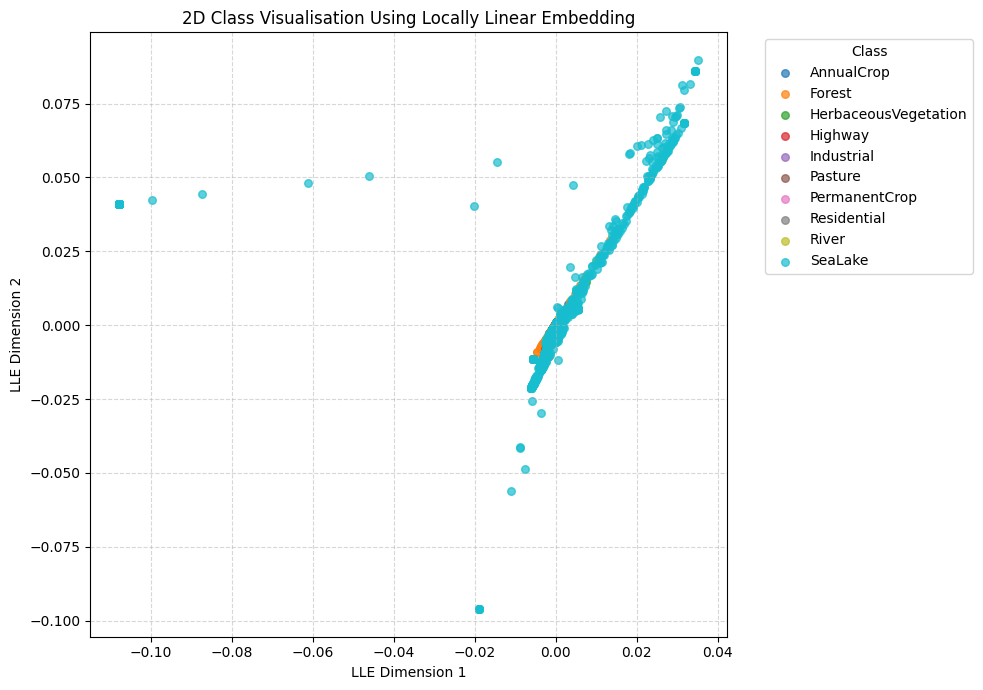

In [21]:
res_q6 = model.q6()
model.visualise_lle_separability(res_q6["embedded_data"], res_q6["labels"])


In [22]:
print(model_obj, losses, train_acc, test_acc)
print(model.best_hyperparams)

MLPClassifier(hidden_layer_sizes=(200,), max_iter=1000, random_state=1,
              solver='sgd') [1.85953457 1.30339299 1.15130764 1.05675809 0.99345625 0.93509755
 0.88982142 0.85168082 0.81276282 0.78253711 0.75477133 0.72581652
 0.70276074 0.68378692 0.65783691 0.64074687 0.62239007 0.60078566
 0.58723568 0.57105247 0.55330833 0.53728556 0.52553122 0.51248077
 0.49993982 0.48745945 0.47362003 0.46491851 0.45563444 0.44285318
 0.43293993 0.41918635 0.41422924 0.40460169 0.39627329 0.38754291
 0.37829868 0.36994959 0.36128061 0.35620884 0.34809443 0.34225712
 0.33425995 0.32826313 0.32200649 0.31681492 0.30950865 0.30358644
 0.29857531 0.29439229 0.28843215 0.28395736 0.27693672 0.27483916
 0.26815223 0.26376463 0.25933399 0.25672259 0.25057086 0.24669048
 0.24352761 0.23996943 0.23749128 0.23130547 0.22942158 0.22658416
 0.2220413  0.21756451 0.21556013 0.21199853 0.21040565 0.2078808
 0.20376792 0.20150791 0.1969221  0.19715697 0.19245346 0.19093539
 0.18586509 0.1853289  0.18224